# Objective
### Produce a multi-class classification supervised learning model to predict product category (prodcat1) a customer is likely to order.

## Notes
### 1. Without an end-product or business goal, I will make assumptions as necessary to guide model design and evaluation.

### 2. Predicting which category "a customer is likely to order" could be framed as a supervised learning task in two most evident ways.
    - Predict the category of a customer's next purchase (for generating web recommendations, for example)
    - Predict each customers' overall propensity toward different categories (for targeted marketing campaigns or personalized category widgets, for example)
#### I have taken the first approach, as the second would be difficult to evaluate without online experiments or large volumes of historical customer orders

### 3. The following notebook documents an MVP using the provided data, ending with a discussion on results, limitations, and potential next steps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, stats

from lightfm import LightFM, cross_validation, evaluation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
# python dependencies for reproduction
!pip install scikit-learn pandas lightfm

#    1. Exploration and understanding of the data sets

In [3]:
# load and format
orders = pd.read_csv('homework1/order.csv')
sessions = pd.read_csv('homework1/online.csv')

orders['orderdate'] = pd.to_datetime(orders['orderdate'])
orders = orders.set_index('orderdate').sort_index()
sessions['dt'] = pd.to_datetime(sessions['dt'])

### Order table EDA 

In [4]:
print(orders.shape)
orders.head()

(263278, 5)


,custno,ordno,prodcat2,prodcat1,revenue
orderdate,,,,,
2016-01-01 05:05:14,67913,143380,38.0,5,139.77
2016-01-01 06:34:56,10880,15272,4.0,2,147.51
2016-01-01 06:34:56,10880,15272,77.0,3,27.70
2016-01-01 06:34:56,10880,15272,39.0,5,69.25
2016-01-01 06:34:56,10880,15272,3.0,2,52.27


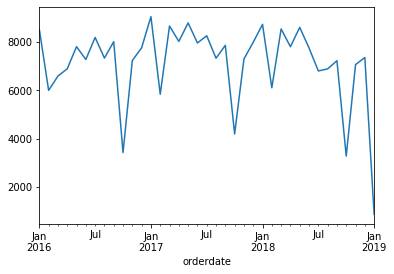

In [5]:
# time-series of orders per month
tmpdf = orders.groupby(pd.Grouper(freq='M'))['ordno'].count().plot()
plt.show()

In [6]:
# frequency of missing data
orders.isna().mean()

custno      0.000000
ordno       0.000000
prodcat2    0.006924
prodcat1    0.000000
revenue     0.000000
dtype: float64

In [7]:
# cardinality of features
orders.nunique()

custno       70264
ordno       149717
prodcat2       251
prodcat1         6
revenue      15001
dtype: int64

In [8]:
# distribution of labels
orders['prodcat1'].value_counts()

2    88684
1    48672
4    46681
3    44019
7    24042
5    11180
Name: prodcat1, dtype: int64

In [9]:
# distribution of labels and revenue per label
orders.groupby('prodcat1')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
prodcat1,,,,,,,,
1,48672.0,74.880807,43.219422,0.00,37.0700,75.120,112.00,150.0
2,88684.0,75.208527,43.299121,0.00,37.7600,75.255,112.62,150.0
3,44019.0,74.747437,43.192556,0.01,37.3400,74.610,112.00,150.0
4,46681.0,74.653734,43.349344,0.00,37.1400,74.550,112.11,150.0
5,11180.0,75.676608,43.065655,0.00,38.7975,75.685,112.90,150.0
7,24042.0,74.627529,43.420142,0.01,36.8425,74.180,112.22,150.0


In [10]:
# mean revenue per sub-category
orders.groupby('prodcat2')['revenue'].mean().describe()

count    251.000000
mean      74.760769
std       13.791414
min        1.970000
25%       72.654076
50%       75.058562
75%       77.959206
max      143.350000
Name: revenue, dtype: float64

In [11]:
# number of orders per customer
orders.groupby('custno')['prodcat1'].count().describe()

count    70264.000000
mean         3.746983
std         11.387488
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        626.000000
Name: prodcat1, dtype: float64

In [12]:
# number of items per order
orders.groupby('ordno')['prodcat1'].count().describe()

count    149717.000000
mean          1.758504
std           1.073511
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          26.000000
Name: prodcat1, dtype: float64

**Notes**
- Categorical label observations don't show strong class imbalance (1:8 between most common and least common)
- Negligible missing data
- Straightforward format; longitudinal customer orders over ~3 year period
- Median # orders per customer = 2. Will likely need to predict cold-start customers; may be challenging to construct a representative test-set
- Surprisingly, little variation in order revenue per category; all in interval [$\$74.00, \$76.00$]


**Assumptions**
- prodcat2 description ("Product category -detail") presumably sub-categories, as they have much higher cardinality than prodcat1. Could search for hierarchical category structure, but that isn't guaranteed for e-commerce catalogs.

### Session table EDA 

Similar structure to orders table; similar EDA process

In [13]:
print(sessions.shape)
sessions.head()

(954774, 7)


,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


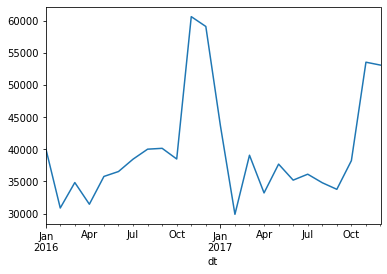

In [14]:
# time-series of orders per month; spike around black friday / holiday season
sessions.set_index('dt').groupby(pd.Grouper(freq='M'))['category'].count().plot()
plt.show()

In [16]:
# sessions and orders start at the same time
orders.index.min(), sessions['dt'].min()

(Timestamp('2016-01-01 05:05:14'), Timestamp('2016-01-01 00:00:08'))

In [17]:
# sessions data terminates before orders
orders.index.max(), sessions['dt'].max()

(Timestamp('2019-01-02 23:54:58'), Timestamp('2017-12-31 23:58:05'))

In [18]:
# event1 is largely NaN; no other columns with missing values
sessions.isna().mean()

session     0.00000
visitor     0.00000
dt          0.00000
custno      0.00000
category    0.00000
event1      0.82726
event2      0.00000
dtype: float64

In [19]:
# cardinality of features
sessions.nunique()

session     850235
visitor     259950
dt          942579
custno       57584
category         3
event1          10
event2          10
dtype: int64

In [20]:
# distribution of session category views
sessions['category'].value_counts()

3    706920
2    194890
1     52964
Name: category, dtype: int64

### NB Sessions category (described as equivalent to orders 'prodcat1' target) only contains labels $\in \{1, 2, 3\}$

In [21]:
print('event 1 values\n', sessions['event1'].dropna().astype(int).unique())

event 1 values
 [ 1  2  4  5  6  7  8  9 10 11]


In [22]:
print('event 2 values\n', sessions['event2'].dropna().astype(int).unique())

event 2 values
 [ 1  2  3  4  5  6  7  8  9 10]


In [23]:
# fraction of obsevations where event1 == event2
tmpdf = sessions.dropna()
(tmpdf['event1'] == tmpdf['event2']).mean()

0.20290065968180054

In [24]:
# number of observations per customer
sessions.groupby('custno')['dt'].count().describe()

count    57584.000000
mean        16.580543
std         25.271940
min          1.000000
25%          3.000000
50%          8.000000
75%         19.000000
max        855.000000
Name: dt, dtype: float64

In [25]:
# number of observations per visitor
sessions.groupby('visitor')['dt'].count().describe()

count    259950.000000
mean          3.672914
std           7.173912
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         440.000000
Name: dt, dtype: float64

**Notes**
- Session table doesn't contain information about orders from categories $\in \{4, 5, 7\}$
- event1 and event2 have similar values, but appear to represent different information (event2 is often NaN, and otherwise has different values than event1 ~80% of the time)
- session information only lasts until end of 2017; orders table lasts until early 2019
- *visitor* column has higher cardinality than *custno*, but less than *session* column. *session* column is unique in roughly 90% of observations. Do not yet understand the difference between visitor and session keys.

In [28]:
print(f"order customers: {orders['custno'].unique().shape[0]}") 
print(f"session customers: {sessions['custno'].unique().shape[0]}") 
print(f"customers in both: {len(set(sessions['custno']) & set(orders['custno']))}")

order customers: 70264
session customers: 57584
customers in both: 56764


#### Nearly all customers with session data have order data present. Many customers with orders have no session data 

#    2. Feature engineering

#### 1. Matrix factorization on session data to obtain customer embeddings. These embeddings could be used for a downstream clustering task to segment customers, and will help to represent the majority of "coldstart" customers having no past purchases

#### 2. Generate a single table containing 
- Features:
    - Customer embeddings from session data
    - Past purchases from each category
    - Average past order value
- Label: product category for a "new" order from the customer
    - prodcat1
    
### NB I will reserve orders after May 2018 as a test set for roughly 80/20 split, eliminating risk of leakage from session data

#### 1. Matrix factorization on session data
#### Treat each session "action" as a unique interaction, defining action as (category, event1, event2)

In [29]:
# encode single session "item" as concatentation of category, event1, & event2
sessions['item'] = sessions['category'].astype(str).str.cat(
    sessions['event1'].astype(str).str.cat(
        sessions['event2'].astype(str),
        sep='_'
    ),
    sep='_'
)
# encode customer/items as indices to construct sparse matrix
item_map = {item: index for index, item in enumerate(sessions['item'].unique())}
customer_map = {customer: index for index, customer in enumerate(sessions['custno'].unique())}

sessions['item_ix'] = sessions['item'].map(item_map)
sessions['cust_ix'] = sessions['custno'].map(customer_map)

In [35]:
# build sparse matrix of customer/action interactions
nitem = len(item_map)
ncustomer = len(customer_map)

observations = sessions.groupby(['cust_ix', 'item_ix'])['item'].count().reset_index()

In [47]:
session_observations = sparse.coo_matrix(
    (np.log10(observations['item']), (observations['cust_ix'], observations['item_ix'])),
    shape=(ncustomer, nitem)
)

print('observation sparsity = '
      f'{session_observations.getnnz() / np.prod(session_observations.shape)}')

observation sparsity = 0.026739862380072896


#### Sparsity is high, but not alarming for matrix factorization. More problematic is long-tailed distribution with most customers having few observations 

In [48]:
train_obs, test_obs = cross_validation.random_train_test_split(
    session_observations, test_percentage=0.2)

#### hand-tune epochs based on single held-out validation set

In [49]:
session_mf = LightFM(
    learning_rate = 0.01,
    no_components = 12,
    loss='bpr'
)

In [50]:
def score_mf(model, test_labels):
    aucs = evaluation.auc_score(model, test_labels, num_threads=8)
    return aucs.mean()

In [51]:
epoch_steps = 2
nepoch = 20
scores = np.zeros(nepoch)

for partial_epoch in range(nepoch):
    session_fm = session_mf.fit_partial(
        interactions=train_obs,
        num_threads=8,
        epochs=epoch_steps
    )
    scores[partial_epoch] = score_mf(session_fm, test_obs)

best model score: 0.806327760219574


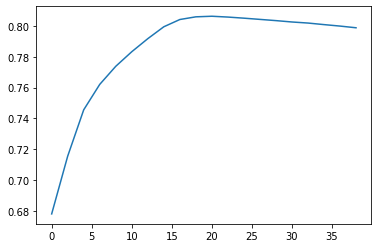

In [52]:
print(f"best model score: {scores.max()}")
plt.plot(epoch_steps*np.arange(nepoch), scores)
plt.show()

#### re-train on all session observations

In [53]:
best_ix = np.argmax(scores)
nepochs = epoch_steps*np.arange(nepoch+1)[best_ix]

session_mf = session_mf.fit(
    interactions=session_observations,
    num_threads=8,
    epochs=nepochs
)

**Notes**

- This model selection procedure has several weaknesses that can be resolved with more time
    - Using a single validation set leads to biased evaluation metrics
    - No tuning has been done on learning_rate, or L2 regularization penalty. Better cross-validation and hyperparameter tuning could improve customer embedding quality. For now, AUC=0.806 should provide meaningful customer embeddings for downstream task

#### get customer-level embeddings 

In [54]:
customer_embeddings = session_mf.get_user_representations()

# concatenate bias and embeddings
customer_embeddings = np.hstack([customer_embeddings[0].reshape(-1,1), customer_embeddings[1]])

customer_embeddings = pd.DataFrame(
    data=customer_embeddings, 
    index=customer_map.keys(), 
    columns=[f'mf_{ix}' for ix in range(customer_embeddings.shape[1])]
).reset_index()

customer_embeddings = customer_embeddings.rename({'index': 'custno'}, axis=1)
customer_embeddings.head()

,custno,mf_0,mf_1,mf_2,mf_3,mf_4,mf_5,mf_6,mf_7,mf_8,mf_9,mf_10,mf_11,mf_12
0,3840,-0.278115,-0.031060,-0.085459,0.096356,-0.033843,0.078167,-0.078196,-0.128470,-0.124178,0.064228,-0.013643,0.104495,0.068513
1,70400,-0.127953,-0.054647,0.008258,-0.012378,-0.031209,-0.012360,-0.048967,0.028010,-0.009035,0.035004,-0.026238,-0.055380,0.031518
2,21248,-0.017517,-0.009145,-0.047696,0.029160,0.006616,0.015962,-0.015539,-0.006532,0.007036,0.012536,0.001593,0.049647,0.015276
3,39168,-0.121958,-0.025755,-0.042915,0.026999,-0.014389,-0.023401,-0.029523,-0.011559,0.010613,0.053792,0.019077,-0.003238,-0.001660
4,47616,-0.269700,0.011937,-0.128861,0.105616,-0.072671,0.178442,-0.012852,-0.122685,-0.145778,0.072799,-0.069370,0.109572,0.130130


#### compute past order features 

In [57]:
# sort dataframe by index (assuming datetime index), and compute average column value with expanding windows
# NB may be incorrect for orders of multiple items; should re-write using pandas datetime operations

CUTOFF_DATE = pd.to_datetime('2018-05')

def past_aggregate_features(df, categories=orders['prodcat1'].unique(), cutoff=CUTOFF_DATE):
    """Featurize all order observations, ignoring observations after CUTOFF_DATE to avoid leakage"""
    df.sort_index()
    df['avg_past_revenue'] = df.expanding()['revenue'].apply(
        lambda xx: xx[xx.index < CUTOFF_DATE].mean()
    )
    
    for category in categories:
        df[f'purchases_{category}'] = df.expanding()['prodcat1'].apply(
            lambda xx: (xx[xx.index < CUTOFF_DATE]==category).sum()
        )

    df = df.fillna(0)
    return df

In [72]:
features = orders.groupby('custno').apply(past_aggregate_features)

#### compile final features/labels for category prediction task 

In [73]:
# concatenate with customer embeddings from session-data
features = features.merge(customer_embeddings, on='custno', how='left').fillna(0)
labels = features['prodcat1'].map({category: index for index, category in enumerate(features['prodcat1'].unique())})
features = features.drop(orders.columns, axis=1)

In [74]:
features.head()

,avg_past_revenue,purchases_5,purchases_2,purchases_3,purchases_4,purchases_1,purchases_7,mf_0,mf_1,mf_2,mf_3,mf_4,mf_5,mf_6,mf_7,mf_8,mf_9,mf_10,mf_11,mf_12
0,139.770000,1.0,0.0,0.0,0.0,0.0,0.0,-0.124167,0.079439,-0.087336,0.033555,-0.019371,0.082448,0.022191,-0.050222,-0.121571,-0.023979,-0.036052,0.076814,0.043387
1,147.510000,0.0,1.0,0.0,0.0,0.0,0.0,-0.039121,0.038823,-0.004926,0.011986,-0.011600,0.035414,-0.014180,-0.038425,-0.008411,-0.048814,-0.003085,0.025505,-0.017249
2,87.605000,0.0,1.0,1.0,0.0,0.0,0.0,-0.039121,0.038823,-0.004926,0.011986,-0.011600,0.035414,-0.014180,-0.038425,-0.008411,-0.048814,-0.003085,0.025505,-0.017249
3,81.486667,1.0,1.0,1.0,0.0,0.0,0.0,-0.039121,0.038823,-0.004926,0.011986,-0.011600,0.035414,-0.014180,-0.038425,-0.008411,-0.048814,-0.003085,0.025505,-0.017249
4,74.182500,1.0,2.0,1.0,0.0,0.0,0.0,-0.039121,0.038823,-0.004926,0.011986,-0.011600,0.035414,-0.014180,-0.038425,-0.008411,-0.048814,-0.003085,0.025505,-0.017249


In [75]:
train_ix, test_ix = (orders.index < pd.to_datetime(CUTOFF_DATE)), (orders.index >= pd.to_datetime(CUTOFF_DATE))
train_features, test_features = features[train_ix], features[test_ix]
train_labels, test_labels = labels[train_ix], labels[test_ix]

print(f"{train_features.shape[1]} train features")
print(f"{train_features.shape[0]} train observations")
print(f"{test_features.shape[0]} test observations")

20 train features
207456 train observations
55822 test observations


#### With only 20 features, and without the need to reduce features for interpretability, I will not perform any explicit feature selection.

#    Model design and sampling

In [94]:
# tune parameters controlling bagging model bias
params = {
    'min_samples_split': stats.randint(2, 24),
    'min_samples_leaf': stats.randint(2, 8),
    'class_weight': ['balanced', None],
    'max_samples': stats.uniform(loc=.6, scale=.4),
    'max_depth': stats.randint(4, 16),
    'max_features': stats.uniform(loc=.5, scale=0.5)
}

# diminishing returns with more estimators; keep fixed
estimator = RandomForestClassifier(
    n_estimators=128,
    n_jobs=-1,
)

# cross-validate on training set to tune hyperparameters
cv = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    scoring='f1_macro',
    cv=3,
    n_iter=50,
    n_jobs=-1,
    refit=True,
    verbose=3
)

In [95]:
cv = cv.fit(train_features, train_labels)

print(f'best score: {cv.best_score_}')
print(f'best params: {cv.best_params_}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 27.6min finished


best score: 0.6538819161274331
best params: {'class_weight': None, 'max_depth': 11, 'max_features': 0.9735936837998398, 'max_samples': 0.8584920021531988, 'min_samples_leaf': 7, 'min_samples_split': 15}


#    Model evaluation

In [96]:
# baseline model evaluation
y_pred = np.ones(test_labels.shape)
baseline_score = f1_score(y_true=test_labels, y_pred=y_pred, average='macro')
print(f'F1-score using majority-class predictor: {baseline_score}')

# Test set evaluation
y_pred = cv.predict(test_features)
score = f1_score(y_true=test_labels, y_pred=y_pred, average='weighted')
print(f'F1-score on test set (weighted by label frequency): {score}')

F1-score using majority-class predictor: 0.07954044309869017
F1-score on test set (weighted by label frequency): 0.28433123892252143


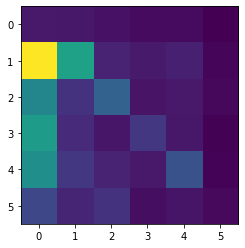

In [97]:
# Confusion matrix
confusion = confusion_matrix(y_true=test_labels, y_pred=y_pred)
plt.imshow(confusion)

In [98]:
# true label distribution
(labels.value_counts()/labels.shape[0]).sort_index()

0    0.042465
1    0.336845
2    0.167196
3    0.177307
4    0.184869
5    0.091318
Name: prodcat1, dtype: float64

In [100]:
# predicted label distribution
(pd.Series(y_pred).value_counts()/y_pred.shape[0]).sort_index()

0    0.469456
1    0.199348
2    0.133567
3    0.076959
4    0.100158
5    0.020512
dtype: float64

#### Oddly, the model predicts label $0$ most often, while it is the least common label. 

#    Summary of results

## Results
I have evaluated the session and order datasets identifying key properties including the lack of product categories ${4, 5, 7}$ in the session data, and the sparsity of order data with the majority of customers having only a single order.

I was able to take advantage of the session data in isolation to learn customer representations based on their session behavior. This wisdom-of-the-crowd approach allows us to having meaningful features for customers, even without past purchase history.

In addition, I constructed interpretable features, focusing on properties of customers' past purchases. Together with customer session representations, I trained a random forest classifier, chosen for its performance on multi-class classification tasks, training speed, and relative simplicity of hyperparameters. Model selection was done with cross-validation optimizing weighted f1-score, since there is no need to weight false positive or false negatives differently, but class imbalance should be accounted for.

Inference with random forests is parallelizable, and session-based representations can be computed periodically in batch, so model deployment should be straightforward for most use cases.

## Limitations
Predictive performance is better than a straw-man model exclusively predicting the majority class. But performance is limited, and the predictions are heavily biased toward the least common label. Additionally, the performance on the test set is much lower than the validation performance, indicating the validation splits are not representative of the test set. More thorough evaluation with a business goal in mind is needed before deployment to customer-facing systems. 


The constructed features and the model design are preliminary, and more time spent in EDA, feature engineering, and model selection is sure to improve performance. Specifically, *prodcat2* was not used in featurization, but sub-category information may resolve differences between customers with similar purchase history. Reproducibility of the notebook is also limited, as this notebook is for demonstration purposes only; I have not take effort to modularize, fix random seeds, or implement unit tests.